# Street View House Number (SVHN) Image Generation

Here we'll try to generate fake images house numbers as if they came from SVHN dataset using DC-GAN

In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Prepare Data

In [2]:
##
# Download the dataset
##

ds = datasets.SVHN(root='svhn_data',
                   split='train',
                   download=True,
                   transform=transforms.ToTensor())
print(ds)

Using downloaded and verified file: svhn_data/train_32x32.mat
Dataset SVHN
    Number of datapoints: 73257
    Root location: svhn_data
    Split: train
    StandardTransform
Transform: ToTensor()


In [3]:
##
# Explore data
##

image = ds[0][0]
label = ds[0][1]
print(f'Image shape: {image.shape}')
print(f'Image min/max: {image.min()} / {image.max()}')
print(f'Label: {label}')
print(f'Image tensor: \n {image}')

Image shape: torch.Size([3, 32, 32])
Image min/max: 0.0470588244497776 / 0.4470588266849518
Label: 1
Image tensor: 
 tensor([[[0.1294, 0.0588, 0.0588,  ..., 0.2824, 0.3216, 0.3490],
         [0.1098, 0.0549, 0.0549,  ..., 0.1569, 0.2627, 0.3255],
         [0.1569, 0.0706, 0.0627,  ..., 0.0902, 0.1373, 0.2824],
         ...,
         [0.3373, 0.3412, 0.3216,  ..., 0.4078, 0.4078, 0.4039],
         [0.3294, 0.3373, 0.3216,  ..., 0.4314, 0.4157, 0.4157],
         [0.3333, 0.3490, 0.3333,  ..., 0.4353, 0.4275, 0.4039]],

        [[0.1176, 0.0902, 0.0667,  ..., 0.2549, 0.3020, 0.3098],
         [0.1529, 0.0980, 0.0784,  ..., 0.1529, 0.2275, 0.3059],
         [0.1608, 0.0824, 0.0667,  ..., 0.1137, 0.1647, 0.2706],
         ...,
         [0.3176, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4118],
         [0.3373, 0.3098, 0.2980,  ..., 0.4039, 0.4118, 0.4078],
         [0.3451, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4157]],

        [[0.1490, 0.0745, 0.0745,  ..., 0.2196, 0.2235, 0.2314],
      

In [4]:
##
# Prepare dataloader
##

dl =  DataLoader(ds, 
                 batch_size=128,
                 shuffle=True,
                 num_workers=4)
print(f'Batch size: {dl.batch_size}')
print(f'Number of batches: {len(dl)}')

Batch size: 128
Number of batches: 573


In [5]:
##
# Function for diaplaying batch of images in a grid
##

def display_images(images, labels=None, n_cols=8, figsize=(12, 6)):
    n_images = images.shape[0]
    n_rows = math.ceil(n_images/n_cols)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    for image_idx in range(n_images):
        # Grab an image tensor and reshape it to plt friendly shape
        image = images[image_idx]
        image = image.permute(1, 2, 0)
        ax = plt.subplot(n_rows, n_cols, image_idx+1)
        ax.imshow(image)
        if labels != None:
            ax.set_title(str(labels[image_idx].item()))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

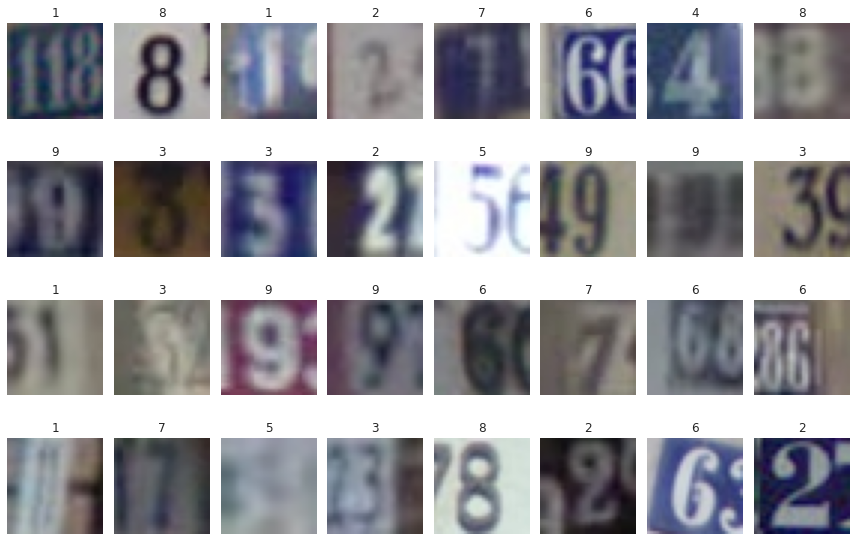

In [6]:
##
# Display one batch of images
##

data_batch = next(iter(dl))
display_images(images=data_batch[0][:32], labels=data_batch[1], figsize=(12, 8))

## Define The Network

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Network definition
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1)   
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc1 = nn.Linear(in_features=8192, out_features=1)

        
    # Feed forward
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)        
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu2(x)            
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu3(x)
        # Flatten shape (batch_size, 512, 4, 4) to (batch_size, 8192)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        logits_out  = self.fc1(x)

        return logits_out

### Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Network definition
        self.fc1 = nn.Linear(in_features=100, out_features=8192)
        self.batch_norm1 = nn.BatchNorm2d(512)       
        self.relu1 = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1) 
        self.batch_norm2= nn.BatchNorm2d(256)       
        self.relu2= nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1) 
        self.batch_norm3= nn.BatchNorm2d(128)
        self.relu3= nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1) 
        self.tanh = nn.Tanh()

      
    # Feed forward
    def forward(self, x):
        x = self.fc1(x)
        # Reshape fc1 output (batch_size, 8192) to correct shape before feeding 
        # to de-conv layer (batch_size, 128 , 4 , 4)
        batch_size = x.shape[0]
        x = x.view(batch_size, 512, 4, 4)
        x = self.batch_norm1(x)
        x = self.relu1(x)              
        x = self.deconv1(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)            
        x = self.deconv2(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.deconv3(x)
        tanh_out = self.tanh(x)

        return tanh_out

### Define the loss function

In [9]:
def real_loss(predictions, device):
    # Get number of predictions we have, this may not be same as batch-size
    # in last batch hence can't use batch-size directly here
    n_preds = predictions.shape[0]
    targets = torch.ones(n_preds).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(predictions.squeeze(), targets)
    
    return loss


def fake_loss(predictions, device):
    n_preds = predictions.shape[0]
    targets = torch.zeros(n_preds).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(predictions.squeeze(), targets)
    
    return loss

## Define Training Loop

In [10]:
def train_svhn_dcgan(discriminator, generator, d_optim, g_optim, device, n_epochs):
    # Define latent vector size
    z_size = 100
    
    # Generate fixed latent vector for whole training, to be used to visulaise
    # generator's training progress in each epoch
    fixed_z = np.random.uniform(-1, 1, (16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
    fixed_samples = []
    
    # Move models to available device
    discriminator = discriminator.to(device)
    generator = generator.to(device)
    
    d_losses = []
    g_losses = []
    print(f'Training on [{device}]...\n')
    for epoch in range(n_epochs):
        # Put models in training mode
        discriminator.train()
        generator.train()
            
        d_epoch_loss = 0
        g_epoch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            ##
            ## Train the discriminator with real images from SVHN dataset
            ##
            # Reset discriminators gradients
            d_optim.zero_grad()
            # Move image to available device
            real_images = real_images.to(device)   
            # Re-scale image data to [-1, 1]
            real_imagse = real_images * 2 - 1
            # Make prediction
            d_logits_real = discriminator(real_images)
            # Compute loss for real images
            d_real_loss = real_loss(d_logits_real, device)

            ##
            ## Train discriminator with fake generated images 
            ##
            # Generate latent vector and move to available device
            z = np.random.uniform(-1, 1, (dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            # Generate fake images
            fake_images =  generator(z)
            # Move image to available device
            fake_images = fake_images.to(device)
            # Make predictions
            d_logits_fake = discriminator(fake_images)
            # Compute loss for fake images
            d_fake_loss = fake_loss(d_logits_fake, device)
            # Compute total discriminator loss and backpropogate
            d_loss =  d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()
            # Keep track of running total batch loss
            d_epoch_loss += d_loss.detach().cpu()

            ##
            ## Train the generator 
            ##        
            # Reset generator's gradients
            g_optim.zero_grad()
            # Generate latent vector and move to available device
            z = np.random.uniform(-1, 1, (dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            # Generate fake images
            fake_images =  generator(z)
            # Make predictions
            g_logits_fake = discriminator(fake_images)
            # Compute generator loss with flip labels
            g_loss = real_loss(g_logits_fake, device)
            # backpropogate
            g_loss.backward()
            g_optim.step()
            # Keep track of running total batch loss
            g_epoch_loss += g_loss.detach().cpu()
            
            if curr_batch % 200 == 0:
                d_losses.append(d_loss)
                g_losses.append(g_loss)
                print(f'Epoch [{epoch+1:3d}/{n_epochs:3d}] batch = {curr_batch}: d_loss = {d_loss:.6f}, g_loss = {g_loss:.6f}')

        ##
        # Generate fake images using fixed latent vector for each epoch
        ##
        generator.eval()
        z = np.random.uniform(-1, 1, (dl.batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images =  generator(z)
        fixed_samples.append(fake_images.detach().cpu())
        
        ##
        # Compute average epoch loss and keep track
        ##
        d_epoch_loss = d_epoch_loss/len(dl)
        g_epoch_loss = g_epoch_loss/len(dl)
        #d_losses.append(d_epoch_loss)
        #g_losses.append(g_epoch_loss)
        
        ##
        # Print training statistics for each epoch
        ##
        #print(f'Epoch [{epoch+1:3d}/{n_epochs:3d}]: d_loss = {d_epoch_loss:.6f}, g_loss = {g_epoch_loss:.6f}')
        
    ##
    ## Save generated fixed images to disk for latter viewing
    ##
    with open('fixed_generated_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

## Train the model

In [11]:
##
# Instantiate models
##

discriminator = Discriminator()
generator = Generator()

# Review model architectures
print(discriminator)
print()
print(generator)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), st

In [12]:
##
# Define optimizers
##
d_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=[0.5, 0.999])
g_optim = optim.Adam(generator.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [13]:
##
# Train
##
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 25
d_losses, g_losses = train_svhn_dcgan(discriminator, 
                                      generator, 
                                      d_optim, 
                                      g_optim,
                                      device,
                                      n_epochs=n_epochs)

Training on [cuda]...

Epoch [  1/ 25] batch = 0: d_loss = 1.376682, g_loss = 2.266763
Epoch [  1/ 25] batch = 200: d_loss = 0.022472, g_loss = 6.413572
Epoch [  1/ 25] batch = 400: d_loss = 0.002318, g_loss = 7.232264
Epoch [  2/ 25] batch = 0: d_loss = 0.323309, g_loss = 3.007701
Epoch [  2/ 25] batch = 200: d_loss = 1.004589, g_loss = 9.979435
Epoch [  2/ 25] batch = 400: d_loss = 0.020483, g_loss = 6.819632
Epoch [  3/ 25] batch = 0: d_loss = 0.464356, g_loss = 7.607308
Epoch [  3/ 25] batch = 200: d_loss = 0.067418, g_loss = 4.200126
Epoch [  3/ 25] batch = 400: d_loss = 0.136554, g_loss = 5.719372
Epoch [  4/ 25] batch = 0: d_loss = 0.206429, g_loss = 3.821216
Epoch [  4/ 25] batch = 200: d_loss = 0.142302, g_loss = 7.890995
Epoch [  4/ 25] batch = 400: d_loss = 1.117320, g_loss = 4.270280
Epoch [  5/ 25] batch = 0: d_loss = 0.297004, g_loss = 2.594531
Epoch [  5/ 25] batch = 200: d_loss = 0.352399, g_loss = 4.219955
Epoch [  5/ 25] batch = 400: d_loss = 0.168939, g_loss = 5.3045

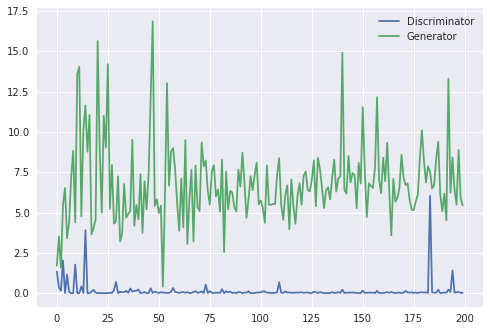

In [55]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [14]:
##
# Load images generated samples during training and visualize
##
with open('fixed_generated_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

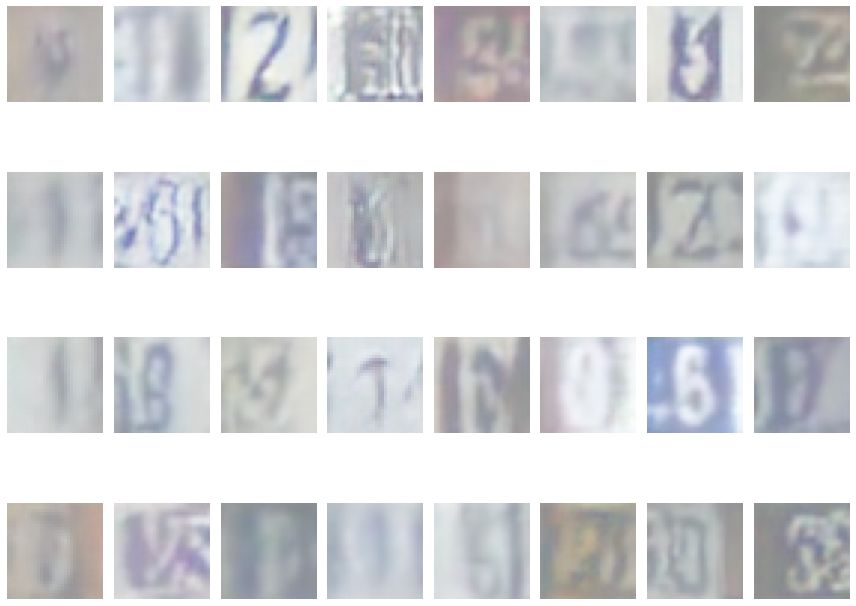

In [26]:
epoch = 25
rescaled_images = (samples[epoch - 1] + 1) / 2
display_images(rescaled_images[:32], figsize=(12, 10))